# Predicting Machine failures

20-02-2026. 

## Libraries

In [1]:
import numpy as np #for arrays and mathematical functions
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #complement to matplotlib
import pandas as pd #data structure and manipulation.
from sklearn.model_selection import train_test_split #for ML
from sklearn.compose import ColumnTransformer #to encode process
from sklearn.preprocessing import OneHotEncoder #to encode process
from sklearn.preprocessing import MinMaxScaler #to normalize wirth min-max method
from sklearn.linear_model import LinearRegression #to implement OLS
import datetime as dt
from sklearn.metrics import mean_absolute_error, r2_score #model eval

## 1. Data import

In [2]:
# 1. Data import
telemetry= pd.read_csv('./machine failures/PdM_telemetry.csv')

telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [3]:
machines= pd.read_csv('./machine failures/PdM_machines.csv')

machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [23]:
failures= pd.read_csv('./machine failures/PdM_failures.csv')

failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


## 2. Data Exploration

In [5]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [6]:
fail_df=failures.groupby(['failure'])['failure'].count()
fail_df

failure
comp1    192
comp2    259
comp3    131
comp4    179
Name: failure, dtype: int64

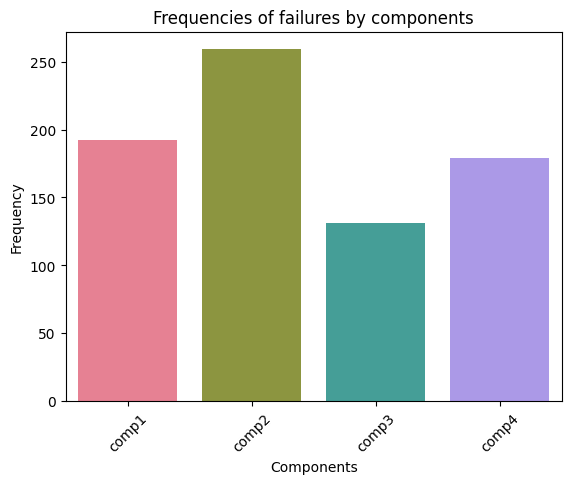

In [7]:
#chosen color palete 
pal = sns.color_palette("husl", 4) #this is a qualitative palette and we chose the first 4 colors

#plot bar x against y 
sns.barplot(x=fail_df.index, y=fail_df.values, hue=fail_df.index, palette=pal, fill=True, legend=False)#, color=colors)

#costumize the plot
plt.title("Frequencies of failures by components")
plt.xlabel("Components")
plt.ylabel("Frequency")
plt.xticks(rotation=45) # Rotate x axis names for better readability

#display the plot
plt.show()

## 3. Data Preprocess

In [30]:
#we assignf the value 1 to every failure to avoid a string issue when doing the regression
failures["failure"]=failures["failure"].replace({"comp1":1, "comp2":2, "comp3":3, "comp4":4})
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,4
1,2015-03-06 06:00:00,1,1
2,2015-04-20 06:00:00,1,2
3,2015-06-19 06:00:00,1,4
4,2015-09-02 06:00:00,1,4


Now we do a *left join* using merge function from pandas, we join by the variables datetime and machineID

In [31]:
df = pd.merge(telemetry, failures, how="left", on=['datetime', 'machineID'])
df.info() 

<class 'pandas.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876142 non-null  str    
 1   machineID  876142 non-null  int64  
 2   volt       876142 non-null  float64
 3   rotate     876142 non-null  float64
 4   pressure   876142 non-null  float64
 5   vibration  876142 non-null  float64
 6   failure    761 non-null     object 
dtypes: float64(4), int64(1), object(1), str(1)
memory usage: 46.8+ MB


In [32]:
# transform date time from string to float to include on the regression
df["datetime"] = pd.to_datetime(df["datetime"])
df["datetime"] = df["datetime"].values.astype("float64")

In [33]:
'''As not every entry on telemetry has a failure we obtained a df with many NaN, 
we fill those NaN with 0'''

df["failure"]=df["failure"].fillna(0)

In [34]:
# check the na replace
df.info() 

<class 'pandas.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876142 non-null  float64
 1   machineID  876142 non-null  int64  
 2   volt       876142 non-null  float64
 3   rotate     876142 non-null  float64
 4   pressure   876142 non-null  float64
 5   vibration  876142 non-null  float64
 6   failure    876142 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 46.8+ MB


### Slicing

In [35]:
# slice
# X (independent variables) are all the features BUT datetime and the failure variable
X = df.drop(["failure"], axis=1) #we drop price from the df
X

# dependent variable
y=df['failure']

In [36]:
X.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,1.420092e+15,1,176.217853,418.504078,113.077935,45.087686
1,1.420096e+15,1,162.879223,402.747490,95.460525,43.413973
2,1.420099e+15,1,170.989902,527.349825,75.237905,34.178847
3,1.420103e+15,1,162.462833,346.149335,109.248561,41.122144
4,1.420106e+15,1,157.610021,435.376873,111.886648,25.990511


In [37]:
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: object

## 4. Training the model

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#to see the dimension of the 4 sets created
[a.shape for a in (X_train, X_test, y_train, y_test)]

[(700913, 6), (175229, 6), (700913,), (175229,)]

In [39]:
# We define our model as linear regresion (OLS)
model = LinearRegression()

# we train our model using the training samples
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


## 5. Making predictions

In [41]:
# we make a prediction of y based on our model and training sample
y_train_hat = model.predict(X_train)
print(f"The first five predicted values are: \n {y_train_hat[:5]} \n")
print(f"While the first actual values on the training sample are: \n {y_train.values[:5]}")

The first five predicted values are: 
 [0.00220194 0.00220318 0.00200036 0.00201342 0.00202872] 

While the first actual values on the training sample are: 
 [0 0 0 0 0]


In [42]:
#again we make a predicion, but now based on the independent variables of the test sample
y_test_hat = model.predict(X_test)
print(f"The first five predicted values are: \n {y_test_hat[:5]} \n")
print(f"While the first actual values on the test sample are: \n {y_test.values[:5]}")

The first five predicted values are: 
 [0.00226554 0.00197983 0.0023098  0.00203436 0.00227835] 

While the first actual values on the test sample are: 
 [0 0 0 0 0]


## 6. Evaluation

In [43]:
# ---------------- EVAL

# we evaluate the model-fit in relation to our testing sample
# calculate MEA score
test_mae = mean_absolute_error(y_test, y_test_hat)

# calculate R2 score
test_r2 = r2_score(y_test, y_test_hat)

print(f"Mean absolute error (testing sample)  = {test_mae}.")
print(f"r-squared score  (testing sample) = {test_r2}.")
print("NOTE: Remember that in the case of R^2 the higher the better")

Mean absolute error (testing sample)  = 0.004069185305109536.
r-squared score  (testing sample) = 2.7094346773948175e-06.
NOTE: Remember that in the case of R^2 the higher the better


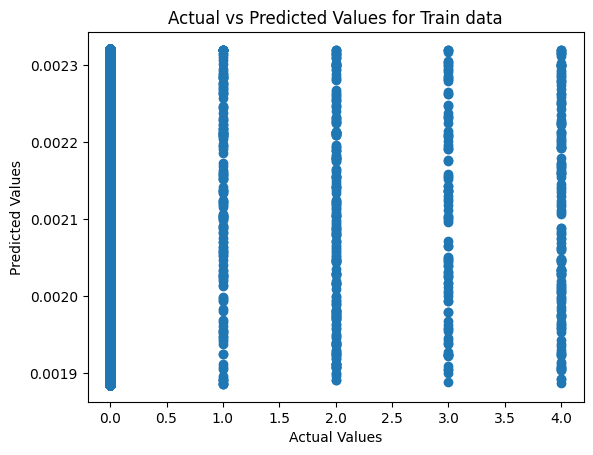

In [44]:
# Plot 1
plt.scatter(y_train, y_train_hat)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for training component failure")

plt.show()

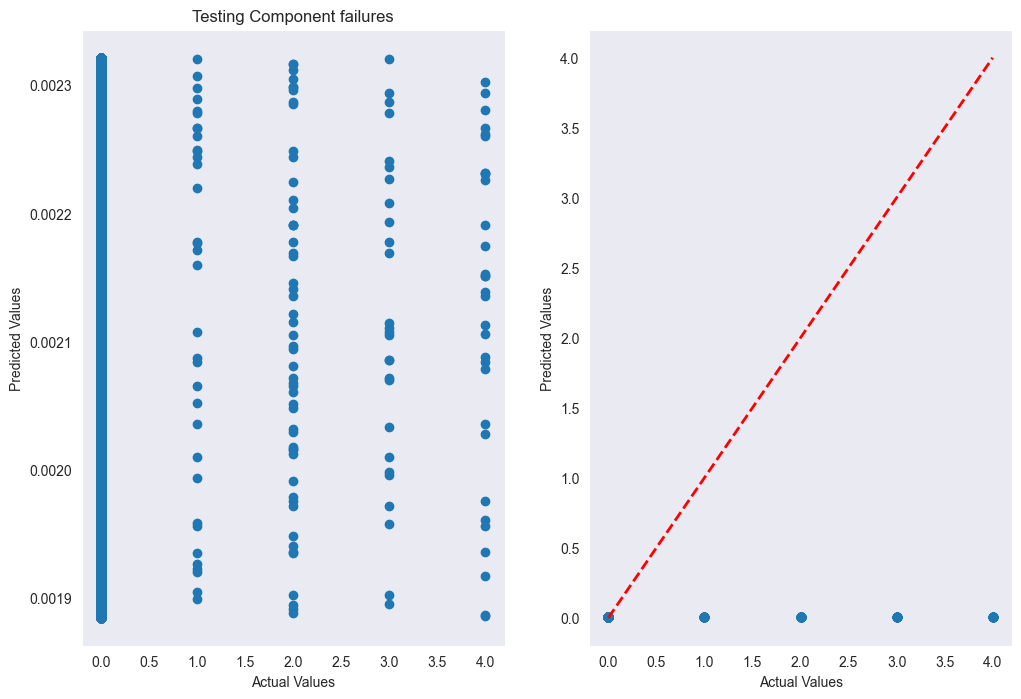

In [70]:
# set style
sns.set_style("dark")

#To stack to plots horizontally 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

# trying to merge the last two 
ax1.scatter(y_test, y_test_hat)
ax1.set_xlabel("Actual Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title("Testing Component failures")

# Create 1:1 reference line
min_val = min(min(y_test), min(y_test_hat))
max_val = max(max(y_test), max(y_test_hat))

ax2.scatter(y_test, y_test_hat)
ax2.set_xlabel("Actual Values")
ax2.set_ylabel("Predicted Values")
#ax2.title("Actual vs Predicted Values for testing Component failurea")
ax2.plot([min_val, max_val], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2)

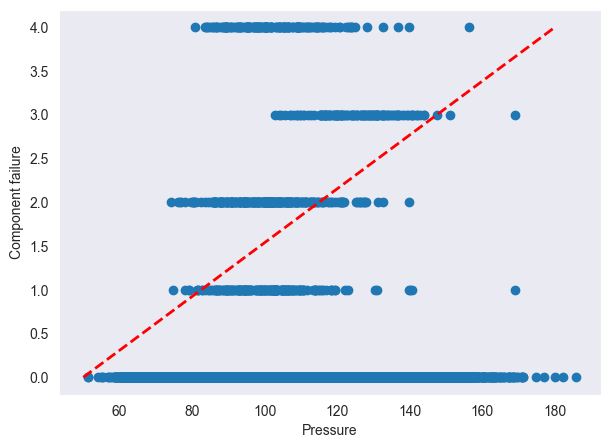

In [67]:
#To stack to plots horizontally 
fig, ax = plt.subplots(figsize=(7,5))

# plot for y vs one of the features
ax.scatter(df['pressure'], df['failure'])
ax.set_xlabel("Pressure")
ax.set_ylabel("Component failure")
#ax1.set_title("Testing Component failures")

ax.plot([50, 180], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2)

## A Diferent approach...